In [2]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 397.csv, 514.csv
📊 데이터 Shape: I=4, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=486.00, M2=924.00


In [3]:
def optimize_without(target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    I_set = [i for i in range(I) if i != target_i]
    M1 = np.maximum(R[I_set], K[I_set, None, None]).max()
    M2 = max(R[I_set].sum(axis=0).max(), K[I_set].sum())

    model = gp.Model(f"set_without_{target_i}")
    model.setParam("MIPGap", 1e-7)
    model.setParam("OutputFlag", 0)

    x = model.addVars(I_set, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    ep = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
    em = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
    yp = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    z = model.addVars(I_set, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
    zc = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
    zd = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
    d = model.addVars(I_set, I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

    p1 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p1")
    p2 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p2")
    p3 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p3")
    p4 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p4")

    obj = gp.quicksum(P_DA[t] * x[i, t] for i in I_set for t in range(T)) + gp.quicksum(
        (1 / S) * (
            P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in I_set) -
            P_PN[t] * gp.quicksum(em[i, t, s] for i in I_set)
        )
        for t in range(T) for s in range(S)
    )
    model.setObjective(obj, GRB.MAXIMIZE)

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
        model.addConstr(yp[i, t, s] <= R[i, t, s])
        model.addConstr(zd[i, t, s] <= z[i, t, s])
        model.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
        model.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
        model.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
        model.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
        model.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
        model.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
        model.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
        model.addConstr(z[i, t, s] <= K[i])
        model.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])

    for i, s in product(I_set, range(S)):
        model.addConstr(z[i, 0, s] == K0[i])

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in I_set if j != i))
        model.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in I_set if j != i))
        model.addConstr(gp.quicksum(ep[i, t, s] for i in I_set) <= M2 * p4[i, t, s])
        model.addConstr(gp.quicksum(em[i, t, s] for i in I_set) <= M2 * (1 - p4[i, t, s]))
        model.addConstr(d[i, i, t, s] == 0)

    model.optimize()

    i_map = {i: idx for idx, i in enumerate(I_set)}

    yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in I_set] for i in I_set])

    return yp_vals, ym_vals, d_vals, i_map

In [4]:
def optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    yp_without = {}
    ym_without = {}
    d_without = {}
    i_map_without = {}

    for target_i in tqdm(range(I), desc="Solving settlement model for each target DER"):
        yp_vals, ym_vals, d_vals, i_map = optimize_without(
            target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S
        )
        yp_without[target_i] = yp_vals
        ym_without[target_i] = ym_vals
        d_without[target_i] = d_vals
        i_map_without[target_i] = i_map

    return yp_without, ym_without, d_without, i_map_without

In [5]:
yp_without, ym_without, d_without, i_map_without = optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S)

Solving settlement model for each target DER:   0%|          | 0/4 [00:00<?, ?it/s]

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  25%|██▌       | 1/4 [00:03<00:10,  3.34s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  50%|█████     | 2/4 [00:05<00:04,  2.44s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Supply-Demand Curve

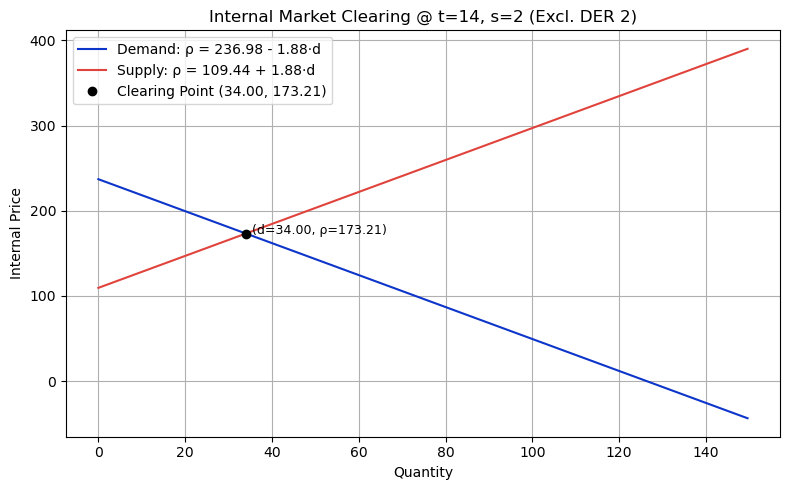

In [6]:
# === 파라미터 설정 ===
target_i = 2
t, s = 14, 2

# === 최적화 결과 불러오기 ===
yp_vals = yp_without[target_i]
ym_vals = ym_without[target_i]
d_vals = d_without[target_i]
i_map = i_map_without[target_i]
I_set = list(i_map.keys())

# === Step 1: 총 공급·수요 및 거래 수익 계산 ===
total_supply = sum(yp_vals[i_map[i], t, s] for i in I_set)
total_demand = sum(ym_vals[i_map[i], t, s] for i in I_set)

given_profit = received_profit = realized_supply = realized_demand = 0
for i in I_set:
    for j in I_set:
        if i == j:
            continue
        given_profit    += d_vals[i_map[i], i_map[j], t, s] * P_PN[t]
        received_profit += d_vals[i_map[j], i_map[i], t, s] * P_RT[t, s]
        realized_supply += d_vals[i_map[i], i_map[j], t, s]
        realized_demand += d_vals[i_map[j], i_map[i], t, s]

# === Step 2: 수요·공급 곡선 계수 계산 ===
a_d = P_PN[t]
b_d = 2 * (a_d * realized_demand - received_profit) / (realized_demand ** 2) if realized_demand > 1e-4 else 0

a_s = P_RT[t, s]
b_s = 2 * (given_profit - a_s * realized_supply) / (realized_supply ** 2) if realized_supply > 1e-4 else 0

# === Step 3: 교차점 계산 ===
denom = b_d + b_s
q_clearing = (a_d - a_s) / denom if abs(denom) > 1e-6 else 0
p_clearing = a_s + b_s * q_clearing

# === Step 4: 시각화 ===
x_max = 1.1 * max(total_demand, total_supply, q_clearing)
quantities = np.linspace(0, x_max, 300)
demand_prices = a_d - b_d * quantities
supply_prices = a_s + b_s * quantities

plt.figure(figsize=(8, 5))
plt.plot(quantities, demand_prices, label=f"Demand: ρ = {a_d:.2f} - {b_d:.2f}·d", color='#0D35C9')
plt.plot(quantities, supply_prices, label=f"Supply: ρ = {a_s:.2f} + {b_s:.2f}·d", color='#E0433C')
plt.plot(q_clearing, p_clearing, 'ko', label=f"Clearing Point ({q_clearing:.2f}, {p_clearing:.2f})")
plt.annotate(f"(d={q_clearing:.2f}, ρ={p_clearing:.2f})", 
             xy=(q_clearing, p_clearing), 
             xytext=(q_clearing + 1.5, p_clearing - 1),
             fontsize=9)

plt.title(f"Internal Market Clearing @ t={t}, s={s} (Excl. DER {target_i})")
plt.xlabel("Quantity")
plt.ylabel("Internal Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Residual Demand Curve

In [7]:
# # === 수요 및 공급 함수 정의 ===
# rho_d = lambda q: a_d - b_d * q  # 수요곡선: ρ_d(q) = a_d - b_d·q
# rho_s = lambda q: a_s + b_s * q  # 공급곡선: ρ_s(q) = a_s + b_s·q

# # === Step 1: Cleared Point 계산 ===
# denominator = b_d + b_s
# q_star = (a_d - a_s) / denominator if denominator != 0 else 0
# p_star = rho_d(q_star)

# # === Step 2: RDC 계산 (타겟 DER이 공급 q₀만큼 제공할 때 가격 변화)
# q0_list = np.linspace(-5, 1.1 * total_supply, 100)
# clearing_quantities = []
# clearing_prices = []

# for q0 in q0_list:
#     # 공급곡선이 오른쪽으로 q₀만큼 평행이동
#     q_cleared = (a_d - a_s + b_s * q0) / (b_d + b_s) if (b_d + b_s) != 0 else 0
#     p_cleared = rho_d(q_cleared)
#     clearing_quantities.append(q0)
#     clearing_prices.append(p_cleared)

# # === Step 3: 수요/공급곡선 (Cleared Point를 원점으로 평행이동)
# x_shifted = np.linspace(-q_star, 1.1 * total_supply - q_star, 300)
# demand_shifted = rho_d(x_shifted + q_star)
# supply_shifted = rho_s(x_shifted + q_star)

# # === Step 4: 시각화
# plt.figure(figsize=(10, 6))

# # (1) 원래 수요/공급곡선 + RDC
# plt.plot(q0_list, clearing_prices, label="RDC", color='#196124')
# plt.plot(quantities, rho_d(quantities), label=f"Demand: ρ = {a_d:.2f} - {b_d:.2f}·q", color='#0D35C9', alpha=0.15)
# plt.plot(quantities, rho_s(quantities), label=f"Supply: ρ = {a_s:.2f} + {b_s:.2f}·q", color='#E0433C', alpha=0.15)

# # (2) Shifted 기준 수요/공급곡선 (q* → 0)
# plt.plot(x_shifted, demand_shifted, label=f"Shifted Demand: ρ = {a_d:.2f} - {b_d:.2f}·(q + {q_star:.2f})", linestyle='-', color='#0D35C9')
# plt.plot(x_shifted, supply_shifted, label=f"Shifted Supply: ρ = {a_s:.2f} + {b_s:.2f}·(q + {q_star:.2f})", linestyle='-', color='#E0433C')
# plt.axvline(0, color="#6C6E6C", linestyle="--", alpha=0.7)
# plt.scatter(0, p_star, color="black", label=f"Cleared Point (0, {p_star:.2f})")


# # === 그래프 설정
# plt.title(f"Residual Demand Curve (RDC) and Shifted Curves @ t={t}, s={s}, Target DER: {target_i}")
# plt.xlabel("Target DER's Internal Supply q₀ (MWh)")
# plt.ylabel("Price (ρ)")
# plt.grid(True)
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()

Residual Supply Curve

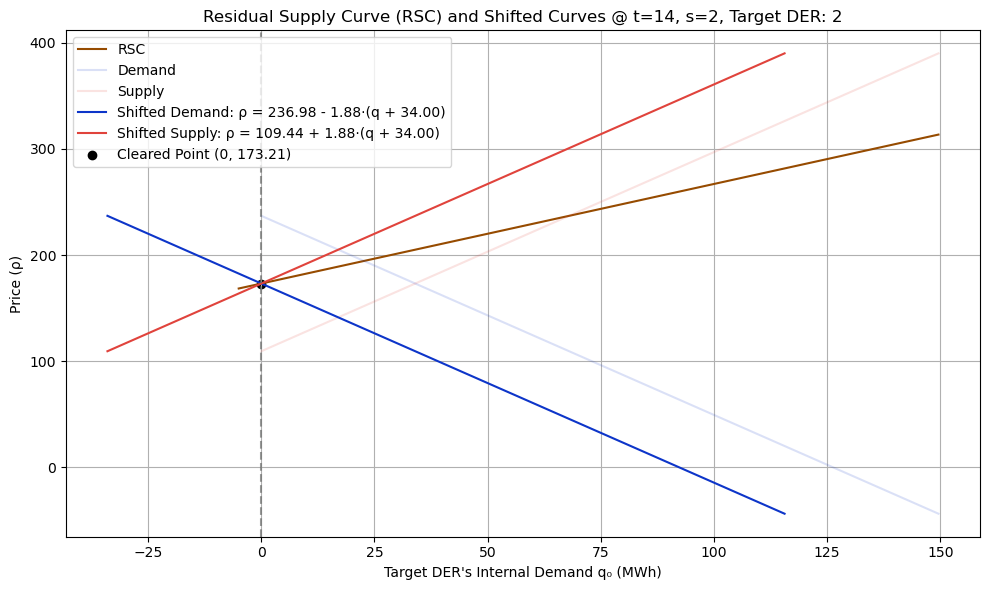

In [8]:
# === 함수 정의 ===
rho_d = lambda q: a_d - b_d * q
rho_s = lambda q: a_s + b_s * q

# === Step 1: Cleared Point ===
denominator = b_d + b_s
q_star = (a_d - a_s) / denominator if denominator != 0 else 0
p_star = rho_s(q_star)

# === Step 2: RSC 계산 (수요곡선 오른쪽으로 q₀ 이동) ===
q0_list = np.linspace(-5, 1.1 * total_supply, 100)
clearing_quantities = []
clearing_prices = []

for q0 in q0_list:
    q_cleared = (a_d + b_d * q0 - a_s) / (b_d + b_s) if (b_d + b_s) != 0 else 0
    p_cleared = rho_s(q_cleared)
    clearing_quantities.append(q0)
    clearing_prices.append(p_cleared)

# === Step 3: Shifted 곡선 (q* 기준 이동)
x_shifted = np.linspace(-q_star, 1.1 * total_demand - q_star, 300)
demand_shifted = rho_d(x_shifted + q_star)
supply_shifted = rho_s(x_shifted + q_star)

# === Step 4: 시각화 ===
plt.figure(figsize=(10, 6))

# (1) RSC
plt.plot(q0_list, clearing_prices, label="RSC", color='#964B00')  # 갈색

# (2) 기존 수요/공급곡선 (희미하게)
plt.plot(quantities, rho_d(quantities), label="Demand", color='#0D35C9', alpha=0.15)
plt.plot(quantities, rho_s(quantities), label="Supply", color='#E0433C', alpha=0.15)

# (3) Shifted 기준 곡선
plt.plot(x_shifted, demand_shifted, label=f"Shifted Demand: ρ = {a_d:.2f} - {b_d:.2f}·(q + {q_star:.2f})", linestyle='-', color='#0D35C9')
plt.plot(x_shifted, supply_shifted, label=f"Shifted Supply: ρ = {a_s:.2f} + {b_s:.2f}·(q + {q_star:.2f})", linestyle='-', color='#E0433C')
plt.axvline(0, color="#6C6E6C", linestyle="--", alpha=0.7)
plt.scatter(0, p_star, color="black", label=f"Cleared Point (0, {p_star:.2f})")

# 설정
plt.title(f"Residual Supply Curve (RSC) and Shifted Curves @ t={t}, s={s}, Target DER: {target_i}")
plt.xlabel("Target DER's Internal Demand q₀ (MWh)")
plt.ylabel("Price (ρ)")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

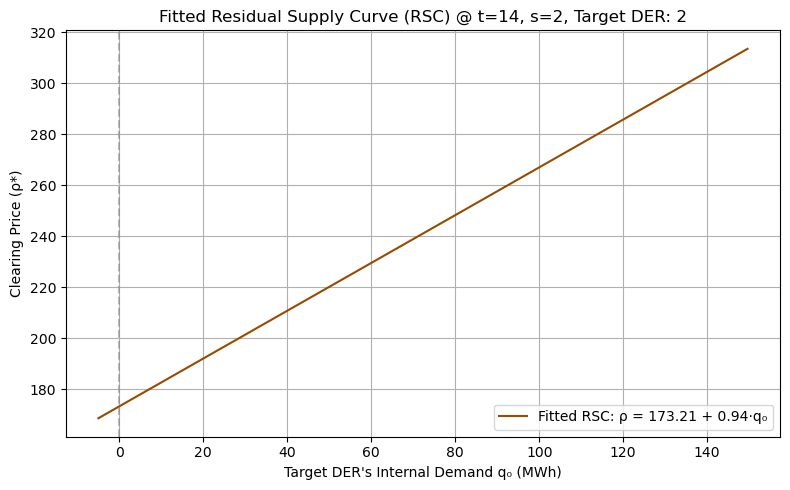

In [9]:
# === Step 1: 데이터 정리 ===
q0_array = np.array(clearing_quantities).reshape(-1, 1)
price_array = np.array(clearing_prices)  # RSC에서 구해진 공급곡선 기반 clearing price

# === Step 2: 다항 회귀 (1차) ===
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(q0_array)

model = LinearRegression()
model.fit(X_poly, price_array)

intercept = model.intercept_
coeffs = model.coef_

# === Step 3: 근사된 RSC 함수 정의 ===
def rsc_poly(q0):
    return intercept + coeffs[1] * q0  # q0은 수요 증가량

# === Step 4: 시각화용 q₀ 범위 설정 ===
q0_smooth = np.linspace(min(q0_list), max(q0_list), 300)
rsc_fitted = rsc_poly(q0_smooth)

# === Step 5: 시각화 ===
plt.figure(figsize=(8, 5))
plt.plot(q0_smooth, rsc_fitted, label=f"Fitted RSC: ρ = {intercept:.2f} + {coeffs[1]:.2f}·q₀", color='#964B00')  # 갈색
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.title(f"Fitted Residual Supply Curve (RSC) @ t={t}, s={s}, Target DER: {target_i}")
plt.xlabel("Target DER's Internal Demand q₀ (MWh)")
plt.ylabel("Clearing Price (ρ*)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()